In [1]:
import numpy as np
from pylab import setp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
%matplotlib inline
import pandas as pd 

## Minkowski Functional Analysis and Permeability Graph

We provide a box plot of the three computed Minkowski functionals as well as the permeability on a comparison graph.

## Permeability Data Loading

We load effective permeability and porosity data from the Stokes simulation output file.

In [2]:
perms = []
phis = []

existing_rows = 0

for i in range(43, 64, 1):
    temp = []
    temp_phi = []
    found = False
    for j, direc in enumerate(["x", "y", "z"]):
        try:
            with open("../../../analysis/perms/beadpack/sampled/128/beadpack_128_"+str(i)+"_summary_calcPerm_"+str(i)+"_"+direc+".txt", "r") as f:
                for row in f:
                    split_row = row.split("\t")
                    k = float(split_row[1].split(" ")[1])
                    phi_eff = float(split_row[3].split(" ")[1])
                temp.append(k)
                temp_phi.append(phi_eff)
            found = True
        except IOError:
            print "No file", i, direc
    if found:
        perms.append(temp)
        phis.append(temp_phi)

perms = np.array(perms)            
phis = np.array(phis)


perms_sample = np.zeros((27, 3))
phis_sample = np.zeros((27, 3))
for i in range(0, 27):
    for j, direc in enumerate(["x", "y", "z"]):                
        with open("../../../analysis/perms/beadpack/original/128/beadpack_128_"+str(i)+"_summary_calcPerm_"+str(i)+"_"+direc+".txt", "r") as f:
            for row in f:
                split_row = row.split("\t")
                k = float(split_row[1].split(" ")[1])
                phi_eff = float(split_row[3].split(" ")[1])
                perms_sample[i, j] = k
                phis_sample[i, j] = phi_eff

## Specific Minkowski Functional Data loading and computation

We compute the specific minkowski functionals by dividing by the domain volume ($200^3$)

In [3]:
berea_original = pd.read_csv("../../../analysis/minkowski_data/beadpack_200_original.csv")
berea_original["Type"] = 0
berea_synthetic = pd.read_csv("../../../analysis/minkowski_data/beadpack_200_dcgan.csv")
berea_synthetic["Type"] = 1

berea_minkowski = pd.concat([berea_original, berea_synthetic])
berea_minkowski["Type"] = berea_minkowski["Type"].astype("category")

berea_original["volume"] /= 200.**3
berea_original["volume"] = (1.-berea_original["volume"])
berea_original["surface"] /= 200.**3
berea_original["euler"] /= 200.**3

berea_synthetic["volume"] /= 200.**3
berea_synthetic["volume"] = (1.-berea_synthetic["volume"])
berea_synthetic["surface"] /= 200.**3
berea_synthetic["euler"] /= 200.**3

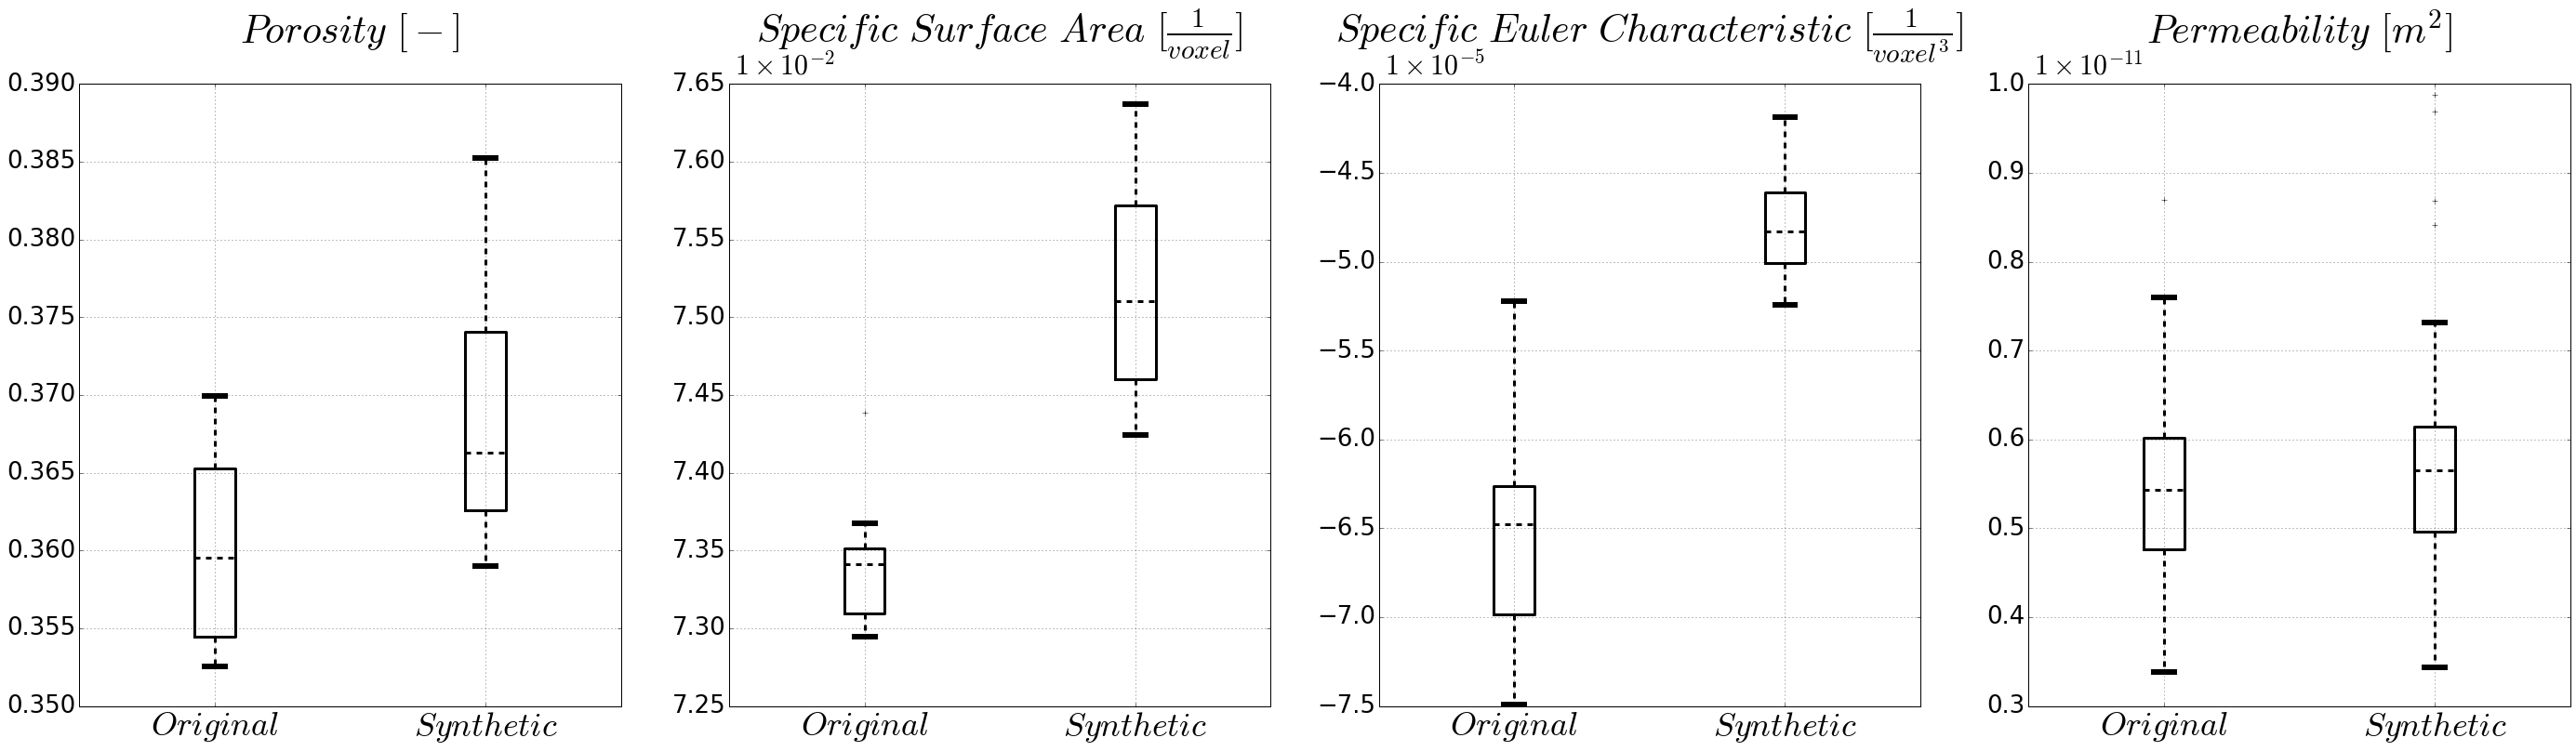

In [4]:
from matplotlib.ticker import ScalarFormatter

def setBoxColors(bp):
    width = 3
    setp(bp['boxes'][0], color='black', linewidth=width)
    setp(bp['boxes'][1], color='black', linewidth=width)
    
    for i in range(4):
        setp(bp['caps'][i], color='black', linewidth=width*2)
        setp(bp['whiskers'][i], color='black', linewidth=width)
        
    setp(bp['fliers'][0], color='black', linewidth=width)
    setp(bp['fliers'][1], color='black', linewidth=width)
    setp(bp['medians'][0], color='black', linewidth=width, linestyle="--")
    setp(bp['medians'][1], color='black', linewidth=width, linestyle="--")
    
fig, ax = plt.subplots(1, 4, figsize=(48, 12))
for i, prop in enumerate(["volume", "surface", "euler", "perm"]):
    if prop == "perm":
        data = [[perms_sample.flatten()], [perms.flatten()]]
        bp = ax[i].boxplot(data)
        setBoxColors(bp)    
    else:
        data = [[berea_original[prop].values], [berea_synthetic[prop].values]]
        bp = ax[i].boxplot(data)
        setBoxColors(bp)
        
        
for j, prop in enumerate([r"Porosity \ [-]", r"Specific \ Surface  \ Area \ [\frac{1}{voxel}]", r"Specific \ Euler \ Characteristic  \ [\frac{1}{voxel^3}]", r"Permeability \ [m^2]"]):
    
    ax[j].set_title(r"$"+prop+r"$", fontsize=42, y=1.06)  
    
fig.canvas.draw()

for i in range(4):
    labels = [item.get_text() for item in ax[i].get_xticklabels()]
    labels[0] = r'$Original$'
    labels[1] = r'$Synthetic$'
    ax[i].set_xticklabels(labels, fontsize=36)  
    
    labels_y = [item.get_text() for item in ax[i].get_yticklabels()]
    ax[i].set_yticklabels(labels_y, fontsize=26)
    ax[i].grid()
    #ax[i].xaxis.set_major_formatter(ScalarFormatter())
    ax[i].yaxis.set_major_formatter(ScalarFormatter())

    if i > 0:
        ax[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax[i].get_yaxis().get_offset_text().set(va='bottom', ha='left')
        ax[i].yaxis.get_offset_text().set_fontsize(26)

for i, s in enumerate([r'$1\times 10^{-2}$', r'$1\times 10^{-5}$', r'$1\times 10^{-11}$']):
    t = ax[i+1].text(0.01, 1.016, s, transform=ax[i+1].transAxes, fontsize=30)
    t.set_bbox(dict(color='white', alpha=1.0, edgecolor=None))  
    
fig.savefig("../../../paper/figures/minkowski_functionals_beadpack_imagej_dcgan_200.png", bbox_extra_artists=None, bbox_inches='tight', dpi=72)